In [252]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

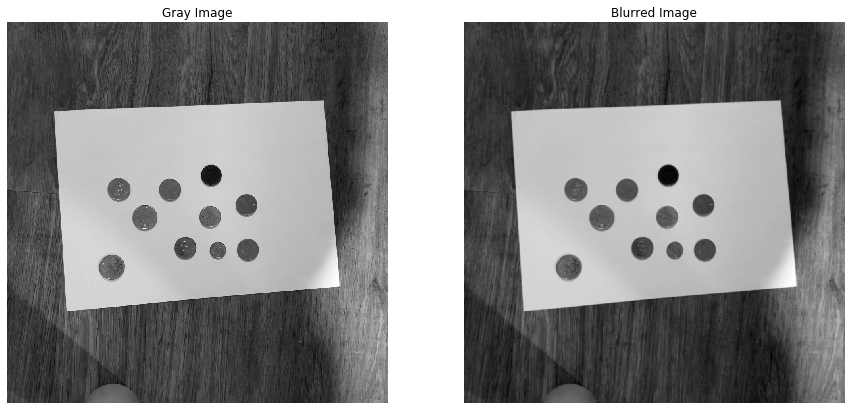

In [294]:
#image 흑백처리, 이진화 (그냥 Threshold)

img = cv2.imread('money.jpg')
img_ori = img.copy()
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Blurring

dst = cv2.bilateralFilter(img_gray, 10, 100, 100) # Bilateral Filtering
dst1 = cv2.GaussianBlur(img_gray, (5,5), 0)       # GaussianBlur
dst2 = cv2.medianBlur(img_gray, 9)                # Median Blur


plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img_gray, cmap='gray'), plt.title('Gray Image'), plt.axis('off')
plt.subplot(122), plt.imshow(dst1, cmap='gray'), plt.title('Blurred Image'), plt.axis('off')
plt.show()

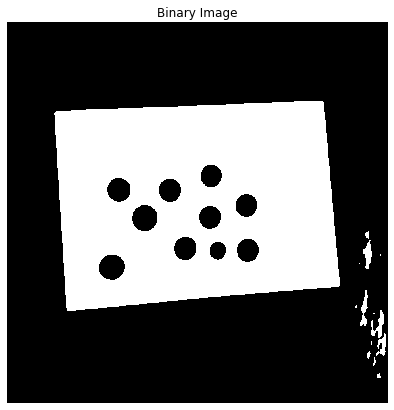

In [295]:
# Thresholding

ret_threshold, binary_img = cv2.threshold(dst2,
                                          170,
                                          255,
                                          cv2.THRESH_BINARY_INV)
binary_img = cv2.bitwise_not(binary_img)


plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(binary_img, cmap='gray'), plt.title('Binary Image'), plt.axis('off')
plt.show()

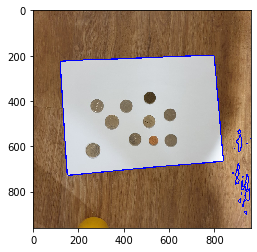

In [296]:
#contour을 찾고 A4용지의 외곽선 그리기
img, contour, hierarchy = cv2.findContours(binary_img, 
                                            cv2.RETR_EXTERNAL, 
                                            cv2.CHAIN_APPROX_SIMPLE)

img = img_ori.copy()

# Draw Contour with Blue
cv2.drawContours(img, contour, -1, (255,0,0), 3)
plt.figure()
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

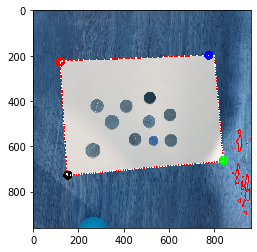

In [297]:
#그려진 외곽선을 바탕으로 꼭짓점 찾기 (perspective point)

cnt=contour[-1]

#좌표점의 순서는 빨->검->파->녹
leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])

# 좌표 표시하기
cv2.circle(img,leftmost,20,(255,0,0),-1) #빨강
cv2.circle(img,rightmost,20,(0,255,0),-1) #녹색
cv2.circle(img,topmost,20,(0,0,255),-1) #파랑
cv2.circle(img,bottommost,20,(0,0,0),-1) #검정

img = cv2.drawContours(img, cnt, -1, (255,255,255), 5)

plt.imshow(img)

In [298]:
print(leftmost)
print(bottommost)
print(topmost)
print(rightmost)

(119, 229)
(153, 727)
(774, 198)
(839, 661)


In [293]:
print(leftmost)
print(bottommost)
print(topmost)
print(rightmost)

(587, 1073)
(2680, 1642)
(1291, 27)
(3073, 195)


In [299]:
#현재 수정중에 있음

points = [leftmost,bottommost,topmost,rightmost]
temppoints = points

print(points)
i = 0
xs=0;
ys=0;
xl=0;
yl=0;
xsmall = 1000;
ysmall = 1000;
xlarge = 0;
ylarge = 0;
for i in range(4):
    print(points[i])
    if(points[i][0] < xsmall) :
        xsmall = points[i][0]
        xs=i
    if(points[i][0] > xlarge):
        xlarge = points[i][0]
        xl=i
    if(points[i][1] < ysmall) :
        ysmall = points[i][1]
        ys=i
    if(points[i][1] > ylarge):
        ylarge = points[i][1]
        yl=i
    print(xsmall, xlarge, ysmall, ylarge)
    print(xs, xl, ys, yl)

leftmost = temppoints[xs]
bottommost = temppoints[yl]
topmost = temppoints[ys]
rightmost = temppoints[xl]

print(leftmost)
print(bottommost)
print(topmost)
print(rightmost)

[(119, 229), (153, 727), (774, 198), (839, 661)]
(119, 229)
119 119 229 229
0 0 0 0
(153, 727)
119 153 229 727
0 1 0 1
(774, 198)
119 774 198 727
0 2 2 1
(839, 661)
119 839 198 727
0 3 2 1
(119, 229)
(153, 727)
(774, 198)
(839, 661)


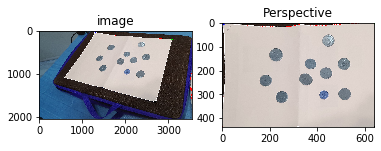

True

In [291]:
#prospective Transform
pts1 = np.float32([topmost, leftmost, rightmost, bottommost])
#pts1 = np.float32([leftmost,bottommost,topmost,rightmost])

# 좌표의 이동점
pts2 = np.float32([[0,0],[0,437],[640,0],[640,437]])

M = cv2.getPerspectiveTransform(pts1, pts2)

dst = cv2.warpPerspective(img, M, (640,437))


plt.subplot(121),plt.imshow(img),plt.title('image')
plt.subplot(122),plt.imshow(dst),plt.title('Perspective')
plt.show()

cv2.imshow('img',dst)
cv2.waitKey(0)
cv2.destroyAllWindows()


# 이미지 저장하기
cv2.imwrite('done.jpg', dst)


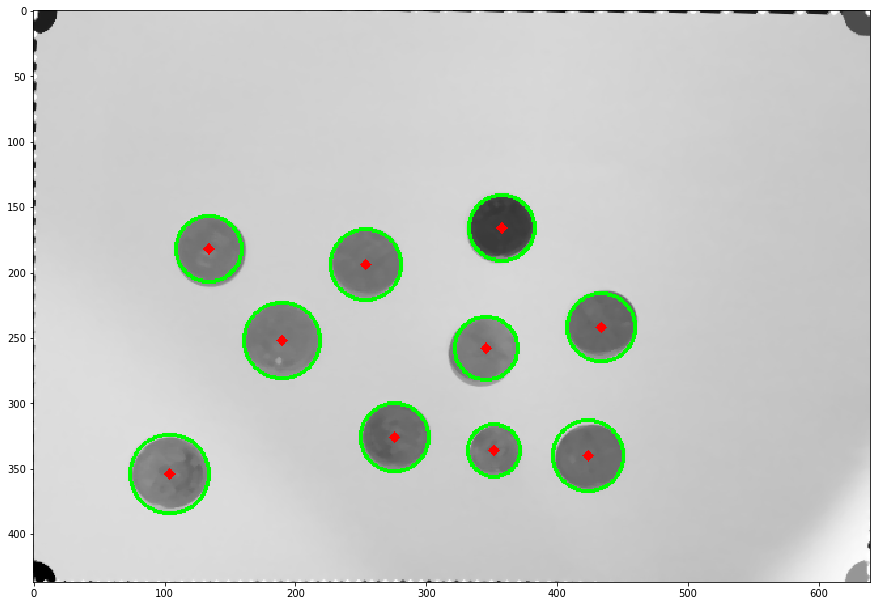

In [259]:
# 방법 1) 한번에 찾는 방법

overlap = cv2.imread('done.jpg', 0)              # 위에서까지 실행한 이미지를 'done.jpg'라고 저장하고, overlap에 불러옴
overlap = cv2.medianBlur(overlap, 5)             # Blur 처리해서 noise를 제거한다
cimg = cv2.cvtColor(overlap, cv2.COLOR_GRAY2BGR)

# 겹친 동전의 모양까지 원으로 검출하는 기준을 정의한다
circles = cv2.HoughCircles(overlap, cv2.HOUGH_GRADIENT, 1, 50, np.array([]), param1=50, param2=25, minRadius=15, maxRadius=50)
circles = np.uint16(np.around(circles))

# 위 조건에 맞춰 cimg에 원을 그린다
for circ in circles[0,:]:
    cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,255,0) ,2)
    cv2.circle(cimg, (circ[0], circ[1]), 2, (255,0,0), 3)


# 원형의 컨투어가 따인 cimg 출력
cv2.imshow('img', cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(figsize=(15,15))
plt.imshow(cimg)
plt.show()

In [260]:
# 방법 2) 함수로 정의해서 원을 하나씩 순차적으로 찾는 방법 (한번에 찾게 수정해도 됨)
# 원을 찾지 못할 경우까지 고려
# 순서가 헷갈리니까 찾을 때 순서를 나타내는 숫자를 넣어야 할까

def findCircle():
    overlap = cv2.imread('done.jpg', 0)
    overlap = cv2.medianBlur(overlap, 5)
    cimg = cv2.cvtColor(overlap, cv2.COLOR_GRAY2BGR)
    
    circles = cv2.HoughCircles(overlap, cv2.HOUGH_GRADIENT, 1, 50, np.array([]),
                               param1=50, param2=25, minRadius=24, maxRadius=50)
    circles = np.uint16(np.around(circles))
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        
        for circ in circles[0,:]:
            cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,255,0), 2)
            cv2.circle(cimg, (circ[0], circ[1]), 2, (255,0,0), 3)
            
            cv2.imshow('Circles detected', cimg)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            
            plt.figure(figsize=(5,5))
            plt.imshow(cimg), plt.axis('off')            
    else:
        print('원을 찾을 수 없음')
    
    plt.show()

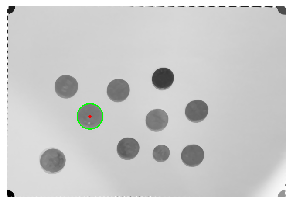

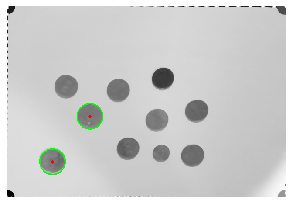

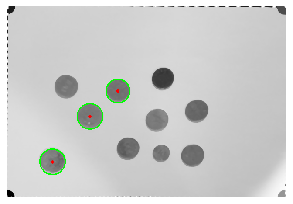

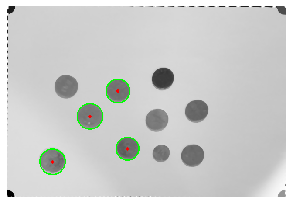

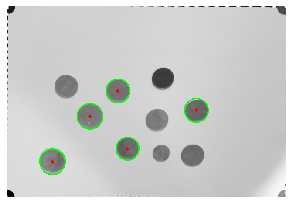

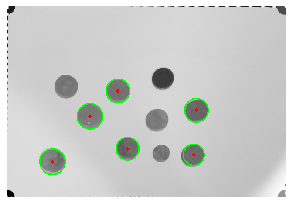

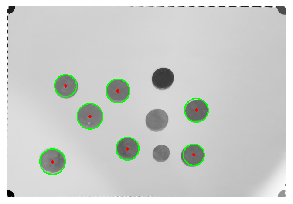

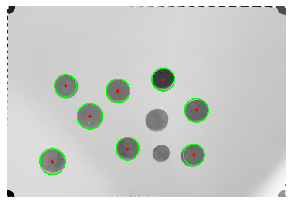

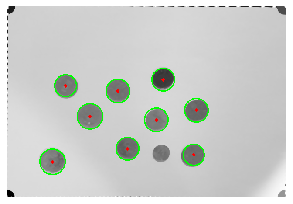

In [261]:
findCircle()

In [262]:
# 동전 좌표 확인하기

count = circles[0,:]        # 인식된 원의 개수를 count라고 지정한다
# len(count)                  # 인식된 원의 개수를 세어서 반환한다
c_array = circles.reshape(len(count), -1)                      # 검출된 원의 개수를 행의 개수로 하는 배열을 array라고 지정한다
radiusSet = c_array[:,-1]

print('\n동전의 (x좌표, y좌표, 반지름) 배열: \n', c_array)     # 여기서 x,y좌표는 원의 중심의 좌표를 의미함
print('\n동전의 반지름 리스트: \n', radiusSet)


동전의 (x좌표, y좌표, 반지름) 배열: 
 [[190 252  29]
 [104 354  30]
 [358 166  25]
 [254 194  27]
 [276 326  26]
 [424 340  27]
 [434 242  26]
 [134 182  25]
 [346 258  24]
 [352 336  20]]

동전의 반지름 리스트: 
 [29 30 25 27 26 27 26 25 24 20]


In [263]:
# 동전 판별하기

# 여기서 동전 판별 기준은 대충 잡았는데 이거 같이 수정수정
# 도대체 반지름 기준을 어케해야 정확할까용

fivehund = 0
onehund = 0
fifty = 0
ten = 0

for j in radiusSet:   
    if j >= 50 or j >= 38 or j >= 28:
        fivehund += 1
    elif j >= 40 or j >= 35 or j >= 24:
        onehund += 1
    elif j >= 30 or j >= 23:
        fifty += 1
    else:
        ten += 1

In [264]:
# 총액 계산하기

total = (500 * fivehund + 100 * onehund + 50 * fifty + 10 * ten)

print('500원: {} 개'.format(fivehund),
      '\n100원: {} 개'.format(onehund),
      '\n 50원: {} 개'.format(fifty),
      '\n 10원: {} 개'.format(ten))
print('동전 총합: {} 원'.format(total))

500원: 2 개 
100원: 7 개 
 50원: 0 개 
 10원: 1 개
동전 총합: 1710 원


In [251]:
import requests
import json

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

def jpy2krw():
    url = 'https://quotation-api-cdn.dunamu.com/v1/forex/recent?codes=FRX.KRWJPY'
    exchange =requests.get(url, headers=headers).json()
    return exchange[0]['basePrice']

def usd2krw():
    url = 'https://quotation-api-cdn.dunamu.com/v1/forex/recent?codes=FRX.KRWUSD'
    exchange =requests.get(url, headers=headers).json()
    return exchange[0]['basePrice']


# 외화 1 단위 --> 원화
usd = usd2krw()
jpy = jpy2krw()

print('환율 : 1 달러 당', usd)
print('환율 : 1 엔 당', jpy / 100)


# 원화 --> 외화
usd_tot = total / usd
jpy_tot = total / (jpy/100)

print('\n총액은 달러로', usd_tot)
print('총액은 엔으로', jpy_tot)

환율 : 1 달러 당 1168.5
환율 : 1 엔 당 10.789000000000001

총액은 달러로 1.0783055198973042
총액은 엔으로 116.78561497821855
